In [21]:
!pip install nltk
!pip install textblob


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 626.3/626.3 kB 7.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [219]:
import nltk
import time
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

plt.style.use('ggplot')

In [214]:
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\c_yw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\c_yw\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\c_yw\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\c_yw\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\c_yw\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [215]:
df = pd.read_csv('data/cleaned_combined_data.csv')

In [216]:
df['row_id'] = df.index + 1
df

,author,text,created_utc,edited,id,num_comments,permalink,score,subreddit_name,upvote_ratio,url,type,post_id,row_id
0,[deleted],My reward for finally finishing my bachelor’s ...,2022-03-29T02:55:49Z,NaN,tqghan,39.0,/r/BMWi3/comments/tqghan/my_reward_for_finally...,223,BMWi3,0.98,https://i.redd.it/qs3elzcr86q81.jpg,post,NaN,1
1,nguit98,100k miles,2024-02-23T08:24:57Z,NaN,1axmm77,36.0,/r/BMWi3/comments/1axmm77/100k_miles/,201,BMWi3,0.98,https://i.redd.it/z4v99nrfb8kc1.jpeg,post,NaN,2
2,labdweller,Rabbit stowage area on the i3,2023-03-14T18:13:18Z,NaN,11r2bh2,14.0,/r/BMWi3/comments/11r2bh2/rabbit_stowage_area_...,192,BMWi3,0.99,https://i.redd.it/yewt745fjona1.jpg,post,NaN,3
3,toteratte21,Picked her up straight from the source in Munich,2023-05-25T16:42:53Z,NaN,13rc663,33.0,/r/BMWi3/comments/13rc663/picked_her_up_straig...,176,BMWi3,0.99,https://i.imgur.com/7jTu2dR.jpg,post,NaN,4
4,azscram9,Picked up this little gem over the weekend,2023-05-22T01:33:12Z,NaN,13o1009,45.0,/r/BMWi3/comments/13o1009/picked_up_this_littl...,173,BMWi3,0.96,https://i.redd.it/w4ilz2ygh91b1.jpg,post,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49361,mariscvaco,Fake Email,2022-06-01T10:31:26Z,NaN,iaqnmqn,NaN,/r/teslamotors/comments/v25ee0/tesla_is_no_lon...,-23,teslamotors,NaN,NaN,comment,t3_v25ee0,49362
49362,[deleted],fake,2022-06-01T11:53:29Z,NaN,iaqwyap,NaN,/r/teslamotors/comments/v25ee0/tesla_is_no_lon...,-33,teslamotors,NaN,NaN,comment,t3_v25ee0,49363
49363,shitaki13,Looks fake. Why would you have to block Elon’s...,2022-06-01T11:09:42Z,NaN,iaqs6p4,NaN,/r/teslamotors/comments/v25ee0/tesla_is_no_lon...,-23,teslamotors,NaN,NaN,comment,t3_v25ee0,49364
49364,jrr6415sun,That’s an email sent to execs though. It doesn...,2022-06-01T11:18:15Z,NaN,iaqt5uv,NaN,/r/teslamotors/comments/v25ee0/tesla_is_no_lon...,-15,teslamotors,NaN,NaN,comment,t3_v25ee0,49365


# VADER
KIV : Does not account for relationship between words

In [217]:
sia = SentimentIntensityAnalyzer()

In [220]:
classified_count = 0

# Start the timer
start_time = time.time()

res = {}
for i,row in tqdm(df.iterrows(), total=len(df)):
    text =row['text']
    myid = row['row_id']
    res[myid]= sia.polarity_scores(text)
    classified_count += 1

elapsed_time = time.time() - start_time

# Calculate the records classified per second
records_per_second = classified_count / elapsed_time

print(f"Total records classified: {classified_count}")
print(f"Time taken: {elapsed_time} seconds")
print(f"Records classified per second: {records_per_second}")
   

  0%|          | 0/49366 [00:00<?, ?it/s]

Total records classified: 49366
Time taken: 16.010634183883667 seconds
Records classified per second: 3083.325709214686


In [221]:
vaders = pd.DataFrame(res).T
vaders =vaders.reset_index().rename(columns={'index':'row_id'})
vaders = vaders.merge(df, how='left')


In [222]:
vaders

,row_id,neg,neu,pos,compound,author,text,created_utc,edited,id,num_comments,permalink,score,subreddit_name,upvote_ratio,url,type,post_id
0,1,0.063,0.673,0.265,0.8275,[deleted],My reward for finally finishing my bachelor’s ...,2022-03-29T02:55:49Z,NaN,tqghan,39.0,/r/BMWi3/comments/tqghan/my_reward_for_finally...,223,BMWi3,0.98,https://i.redd.it/qs3elzcr86q81.jpg,post,NaN
1,2,0.000,1.000,0.000,0.0000,nguit98,100k miles,2024-02-23T08:24:57Z,NaN,1axmm77,36.0,/r/BMWi3/comments/1axmm77/100k_miles/,201,BMWi3,0.98,https://i.redd.it/z4v99nrfb8kc1.jpeg,post,NaN
2,3,0.000,1.000,0.000,0.0000,labdweller,Rabbit stowage area on the i3,2023-03-14T18:13:18Z,NaN,11r2bh2,14.0,/r/BMWi3/comments/11r2bh2/rabbit_stowage_area_...,192,BMWi3,0.99,https://i.redd.it/yewt745fjona1.jpg,post,NaN
3,4,0.000,0.808,0.192,0.2263,toteratte21,Picked her up straight from the source in Munich,2023-05-25T16:42:53Z,NaN,13rc663,33.0,/r/BMWi3/comments/13rc663/picked_her_up_straig...,176,BMWi3,0.99,https://i.imgur.com/7jTu2dR.jpg,post,NaN
4,5,0.000,1.000,0.000,0.0000,azscram9,Picked up this little gem over the weekend,2023-05-22T01:33:12Z,NaN,13o1009,45.0,/r/BMWi3/comments/13o1009/picked_up_this_littl...,173,BMWi3,0.96,https://i.redd.it/w4ilz2ygh91b1.jpg,post,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49361,49362,0.756,0.244,0.000,-0.4767,mariscvaco,Fake Email,2022-06-01T10:31:26Z,NaN,iaqnmqn,NaN,/r/teslamotors/comments/v25ee0/tesla_is_no_lon...,-23,teslamotors,NaN,NaN,comment,t3_v25ee0
49362,49363,1.000,0.000,0.000,-0.4767,[deleted],fake,2022-06-01T11:53:29Z,NaN,iaqwyap,NaN,/r/teslamotors/comments/v25ee0/tesla_is_no_lon...,-33,teslamotors,NaN,NaN,comment,t3_v25ee0
49363,49364,0.305,0.558,0.137,-0.5106,shitaki13,Looks fake. Why would you have to block Elon’s...,2022-06-01T11:09:42Z,NaN,iaqs6p4,NaN,/r/teslamotors/comments/v25ee0/tesla_is_no_lon...,-23,teslamotors,NaN,NaN,comment,t3_v25ee0
49364,49365,0.000,1.000,0.000,0.0000,jrr6415sun,That’s an email sent to execs though. It doesn...,2022-06-01T11:18:15Z,NaN,iaqt5uv,NaN,/r/teslamotors/comments/v25ee0/tesla_is_no_lon...,-15,teslamotors,NaN,NaN,comment,t3_v25ee0


In [223]:
def get_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'
def get_subjectivity(compound_score):
    if compound_score !=0 :
        return 'subjective' 
    else:
        return 'objective'
    
vaders['vader_sentiment'] = vaders['compound'].apply(get_sentiment)
vaders['vader_subjectivity'] = vaders['compound'].apply(get_subjectivity)


In [224]:
vaders

,row_id,neg,neu,pos,compound,author,text,created_utc,edited,id,num_comments,permalink,score,subreddit_name,upvote_ratio,url,type,post_id,vader_sentiment,vader_subjectivity
0,1,0.063,0.673,0.265,0.8275,[deleted],My reward for finally finishing my bachelor’s ...,2022-03-29T02:55:49Z,NaN,tqghan,39.0,/r/BMWi3/comments/tqghan/my_reward_for_finally...,223,BMWi3,0.98,https://i.redd.it/qs3elzcr86q81.jpg,post,NaN,positive,subjective
1,2,0.000,1.000,0.000,0.0000,nguit98,100k miles,2024-02-23T08:24:57Z,NaN,1axmm77,36.0,/r/BMWi3/comments/1axmm77/100k_miles/,201,BMWi3,0.98,https://i.redd.it/z4v99nrfb8kc1.jpeg,post,NaN,neutral,objective
2,3,0.000,1.000,0.000,0.0000,labdweller,Rabbit stowage area on the i3,2023-03-14T18:13:18Z,NaN,11r2bh2,14.0,/r/BMWi3/comments/11r2bh2/rabbit_stowage_area_...,192,BMWi3,0.99,https://i.redd.it/yewt745fjona1.jpg,post,NaN,neutral,objective
3,4,0.000,0.808,0.192,0.2263,toteratte21,Picked her up straight from the source in Munich,2023-05-25T16:42:53Z,NaN,13rc663,33.0,/r/BMWi3/comments/13rc663/picked_her_up_straig...,176,BMWi3,0.99,https://i.imgur.com/7jTu2dR.jpg,post,NaN,positive,subjective
4,5,0.000,1.000,0.000,0.0000,azscram9,Picked up this little gem over the weekend,2023-05-22T01:33:12Z,NaN,13o1009,45.0,/r/BMWi3/comments/13o1009/picked_up_this_littl...,173,BMWi3,0.96,https://i.redd.it/w4ilz2ygh91b1.jpg,post,NaN,neutral,objective
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49361,49362,0.756,0.244,0.000,-0.4767,mariscvaco,Fake Email,2022-06-01T10:31:26Z,NaN,iaqnmqn,NaN,/r/teslamotors/comments/v25ee0/tesla_is_no_lon...,-23,teslamotors,NaN,NaN,comment,t3_v25ee0,negative,subjective
49362,49363,1.000,0.000,0.000,-0.4767,[deleted],fake,2022-06-01T11:53:29Z,NaN,iaqwyap,NaN,/r/teslamotors/comments/v25ee0/tesla_is_no_lon...,-33,teslamotors,NaN,NaN,comment,t3_v25ee0,negative,subjective
49363,49364,0.305,0.558,0.137,-0.5106,shitaki13,Looks fake. Why would you have to block Elon’s...,2022-06-01T11:09:42Z,NaN,iaqs6p4,NaN,/r/teslamotors/comments/v25ee0/tesla_is_no_lon...,-23,teslamotors,NaN,NaN,comment,t3_v25ee0,negative,subjective
49364,49365,0.000,1.000,0.000,0.0000,jrr6415sun,That’s an email sent to execs though. It doesn...,2022-06-01T11:18:15Z,NaN,iaqt5uv,NaN,/r/teslamotors/comments/v25ee0/tesla_is_no_lon...,-15,teslamotors,NaN,NaN,comment,t3_v25ee0,neutral,objective


In [225]:
#id unique test
def are_all_unique(column):
    return not column.duplicated().any()

is_unique = are_all_unique(vaders['id'])

if is_unique:
    print("All entries in the column are unique.")
else:
    print("There are duplicate entries in the column.")

All entries in the column are unique.


In [226]:
new_column_names = {
    'neg': 'vader_neg',
    'neu': 'vader_neu',
    'pos': 'vader_pos',
    'compound': 'vader_compound',
    
}

vaders.rename(columns=new_column_names, inplace=True)

In [227]:
vaders

,row_id,vader_neg,vader_neu,vader_pos,vader_compound,author,text,created_utc,edited,id,num_comments,permalink,score,subreddit_name,upvote_ratio,url,type,post_id,vader_sentiment,vader_subjectivity
0,1,0.063,0.673,0.265,0.8275,[deleted],My reward for finally finishing my bachelor’s ...,2022-03-29T02:55:49Z,NaN,tqghan,39.0,/r/BMWi3/comments/tqghan/my_reward_for_finally...,223,BMWi3,0.98,https://i.redd.it/qs3elzcr86q81.jpg,post,NaN,positive,subjective
1,2,0.000,1.000,0.000,0.0000,nguit98,100k miles,2024-02-23T08:24:57Z,NaN,1axmm77,36.0,/r/BMWi3/comments/1axmm77/100k_miles/,201,BMWi3,0.98,https://i.redd.it/z4v99nrfb8kc1.jpeg,post,NaN,neutral,objective
2,3,0.000,1.000,0.000,0.0000,labdweller,Rabbit stowage area on the i3,2023-03-14T18:13:18Z,NaN,11r2bh2,14.0,/r/BMWi3/comments/11r2bh2/rabbit_stowage_area_...,192,BMWi3,0.99,https://i.redd.it/yewt745fjona1.jpg,post,NaN,neutral,objective
3,4,0.000,0.808,0.192,0.2263,toteratte21,Picked her up straight from the source in Munich,2023-05-25T16:42:53Z,NaN,13rc663,33.0,/r/BMWi3/comments/13rc663/picked_her_up_straig...,176,BMWi3,0.99,https://i.imgur.com/7jTu2dR.jpg,post,NaN,positive,subjective
4,5,0.000,1.000,0.000,0.0000,azscram9,Picked up this little gem over the weekend,2023-05-22T01:33:12Z,NaN,13o1009,45.0,/r/BMWi3/comments/13o1009/picked_up_this_littl...,173,BMWi3,0.96,https://i.redd.it/w4ilz2ygh91b1.jpg,post,NaN,neutral,objective
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49361,49362,0.756,0.244,0.000,-0.4767,mariscvaco,Fake Email,2022-06-01T10:31:26Z,NaN,iaqnmqn,NaN,/r/teslamotors/comments/v25ee0/tesla_is_no_lon...,-23,teslamotors,NaN,NaN,comment,t3_v25ee0,negative,subjective
49362,49363,1.000,0.000,0.000,-0.4767,[deleted],fake,2022-06-01T11:53:29Z,NaN,iaqwyap,NaN,/r/teslamotors/comments/v25ee0/tesla_is_no_lon...,-33,teslamotors,NaN,NaN,comment,t3_v25ee0,negative,subjective
49363,49364,0.305,0.558,0.137,-0.5106,shitaki13,Looks fake. Why would you have to block Elon’s...,2022-06-01T11:09:42Z,NaN,iaqs6p4,NaN,/r/teslamotors/comments/v25ee0/tesla_is_no_lon...,-23,teslamotors,NaN,NaN,comment,t3_v25ee0,negative,subjective
49364,49365,0.000,1.000,0.000,0.0000,jrr6415sun,That’s an email sent to execs though. It doesn...,2022-06-01T11:18:15Z,NaN,iaqt5uv,NaN,/r/teslamotors/comments/v25ee0/tesla_is_no_lon...,-15,teslamotors,NaN,NaN,comment,t3_v25ee0,neutral,objective


In [233]:
def tbSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def tbPolarity(text):
    return TextBlob(text).sentiment.polarity
  
 #Create two new columns ‘Subjectivity’ & ‘Polarity’
total_records = len(vaders)
vaders["tbsubjectivityscore"] =   vaders["text"].apply(tbSubjectivity)
start_time = time.time()
vaders["tbpolarityscore"] = vaders["text"].apply(tbPolarity)

end_time = time.time()

# Calculate the time taken
time_taken = end_time - start_time

# Calculate records classified per second
records_per_second = total_records / time_taken

print("Total Records:", total_records)
print("Time Taken (seconds):", time_taken)
print("Records Classified Per Second:", records_per_second)

def calculate_sentiment(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'
vaders["textblob_sentiment"] = vaders["tbpolarityscore"].apply(calculate_sentiment)


Total Records: 49366
Time Taken (seconds): 12.339229345321655
Records Classified Per Second: 4000.7360766591814


In [229]:
def get_tbsubjectivity(textblob_subjectivity):
    if textblob_subjectivity > 0.5 :
        return 'subjective' 
    else:
        return 'objective'
    
vaders["textblob_subjectivity"] = vaders['tbsubjectivityscore'].apply(get_tbsubjectivity)

In [230]:
vaders = vaders[['row_id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound', 'vader_sentiment','vader_subjectivity','tbpolarityscore','textblob_sentiment','tbsubjectivityscore','textblob_subjectivity', 'author', 'text', 'created_utc', 'edited', 'id', 'num_comments', 'permalink', 'score', 'subreddit_name', 'upvote_ratio', 'url', 'type', 'post_id']]

In [231]:
vaders

,row_id,vader_neg,vader_neu,vader_pos,vader_compound,vader_sentiment,vader_subjectivity,tbpolarityscore,textblob_sentiment,tbsubjectivityscore,...,edited,id,num_comments,permalink,score,subreddit_name,upvote_ratio,url,type,post_id
0,1,0.063,0.673,0.265,0.8275,positive,subjective,0.28125,positive,0.833333,...,NaN,tqghan,39.0,/r/BMWi3/comments/tqghan/my_reward_for_finally...,223,BMWi3,0.98,https://i.redd.it/qs3elzcr86q81.jpg,post,NaN
1,2,0.000,1.000,0.000,0.0000,neutral,objective,0.00000,neutral,0.000000,...,NaN,1axmm77,36.0,/r/BMWi3/comments/1axmm77/100k_miles/,201,BMWi3,0.98,https://i.redd.it/z4v99nrfb8kc1.jpeg,post,NaN
2,3,0.000,1.000,0.000,0.0000,neutral,objective,0.00000,neutral,0.000000,...,NaN,11r2bh2,14.0,/r/BMWi3/comments/11r2bh2/rabbit_stowage_area_...,192,BMWi3,0.99,https://i.redd.it/yewt745fjona1.jpg,post,NaN
3,4,0.000,0.808,0.192,0.2263,positive,subjective,0.20000,positive,0.400000,...,NaN,13rc663,33.0,/r/BMWi3/comments/13rc663/picked_her_up_straig...,176,BMWi3,0.99,https://i.imgur.com/7jTu2dR.jpg,post,NaN
4,5,0.000,1.000,0.000,0.0000,neutral,objective,-0.18750,negative,0.500000,...,NaN,13o1009,45.0,/r/BMWi3/comments/13o1009/picked_up_this_littl...,173,BMWi3,0.96,https://i.redd.it/w4ilz2ygh91b1.jpg,post,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49361,49362,0.756,0.244,0.000,-0.4767,negative,subjective,-0.50000,negative,1.000000,...,NaN,iaqnmqn,NaN,/r/teslamotors/comments/v25ee0/tesla_is_no_lon...,-23,teslamotors,NaN,NaN,comment,t3_v25ee0
49362,49363,1.000,0.000,0.000,-0.4767,negative,subjective,-0.50000,negative,1.000000,...,NaN,iaqwyap,NaN,/r/teslamotors/comments/v25ee0/tesla_is_no_lon...,-33,teslamotors,NaN,NaN,comment,t3_v25ee0
49363,49364,0.305,0.558,0.137,-0.5106,negative,subjective,-0.15000,negative,0.850000,...,NaN,iaqs6p4,NaN,/r/teslamotors/comments/v25ee0/tesla_is_no_lon...,-23,teslamotors,NaN,NaN,comment,t3_v25ee0
49364,49365,0.000,1.000,0.000,0.0000,neutral,objective,0.00000,neutral,0.000000,...,NaN,iaqt5uv,NaN,/r/teslamotors/comments/v25ee0/tesla_is_no_lon...,-15,teslamotors,NaN,NaN,comment,t3_v25ee0


In [40]:
vaders.to_csv('VadersTextBlobCombinedData.csv', index=False)

In [183]:
annotateddf = pd.read_csv('popular_comment_Bolt_annotate_Merged.csv')

In [184]:
annotateddf

,text,score,neg_score,neu_score,pos_score,label,annotator 1,irony 1,remove 1,annotator 2,irony 2,remove 2
0,An Ultium based Bolt with NACS and faster char...,219,0.004940,0.088701,0.906359,positive,0,0,NaN,0,0,NaN
1,They had to have something smaller than the Eq...,141,0.378837,0.540830,0.080333,neutral,-1,0,NaN,-1,1,NaN
2,Yes! I just came back to post this very same t...,55,0.003039,0.012690,0.984271,positive,1,0,NaN,1,0,NaN
3,Yes!!! So excited! Was thinking I was going to...,52,0.017278,0.055458,0.927264,positive,1,0,NaN,1,0,NaN
4,Interesting that they dropped the EV/EUV namep...,21,0.032266,0.881413,0.086321,neutral,0,1,NaN,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1191,"I coasted down a 6,000 feet mountain once… doe...",31,0.027956,0.749923,0.222121,neutral,0,0,NaN,0,0,NaN
1192,He's either driving slowly or driving in warm ...,21,0.805127,0.180456,0.014417,negative,-1,0,NaN,-1,0,NaN
1193,Do we have any idea what the record is for Bol...,4,0.018869,0.936033,0.045098,neutral,0,0,NaN,0,0,NaN
1194,I'll bet he hypermiles at 40mph on the Interst...,14,0.185064,0.530014,0.284922,neutral,0,0,NaN,0,0,NaN


In [185]:
merged_df = pd.merge(annotateddf, vaders, on='text', how='inner')

In [186]:
print(merged_df.columns)

Index(['text', 'score_x', 'neg_score', 'neu_score', 'pos_score', 'label',
       'annotator 1', 'irony 1', 'remove 1', 'annotator 2', 'irony 2',
       'remove 2', 'row_id', 'vader_neg', 'vader_neu', 'vader_pos',
       'vader_compound', 'vader_sentiment', 'vader_subjectivity',
       'tbpolarityscore', 'textblob_sentiment', 'tbsubjectivityscore',
       'textblob_subjectivity', 'author', 'created_utc', 'edited', 'id',
       'num_comments', 'permalink', 'score_y', 'subreddit_name',
       'upvote_ratio', 'url', 'type', 'post_id'],
      dtype='object')


In [187]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import cohen_kappa_score

In [188]:
kappa = cohen_kappa_score(merged_df['annotator 1'], merged_df['annotator 2'])

print("Cohen's Kappa:", kappa)

Cohen's Kappa: 0.8391246687137581


In [189]:
merged_df['annotator_combined'] = np.where(merged_df['annotator 1'] == merged_df['annotator 2'], merged_df['annotator 1'], np.nan)
print(merged_df['annotator_combined'])
valid_count = merged_df['annotator_combined'].count()
print(valid_count)
merged_df.dropna(subset=['annotator_combined'], inplace=True)


0       0.0
1      -1.0
2       1.0
3       1.0
4       0.0
       ... 
1191    0.0
1192   -1.0
1193    0.0
1194    0.0
1195    1.0
Name: annotator_combined, Length: 1196, dtype: float64
1068


In [190]:
merged_df['annotator_combined'] = merged_df['annotator_combined'].astype(str)
sentiment_mapping = {'-1.0': 'negative', '0.0': 'neutral', '1.0': 'positive'}

merged_df['annotator_combined'] = merged_df['annotator_combined'].replace(sentiment_mapping)

In [191]:
print(merged_df['vader_sentiment'])
print(merged_df['annotator_combined'])

0       positive
1       positive
2       positive
3       positive
4       positive
          ...   
1191     neutral
1192    negative
1193     neutral
1194     neutral
1195    positive
Name: vader_sentiment, Length: 1068, dtype: object
0        neutral
1       negative
2       positive
3       positive
4        neutral
          ...   
1191     neutral
1192    negative
1193     neutral
1194     neutral
1195    positive
Name: annotator_combined, Length: 1068, dtype: object


# Weighted  Avg Scores

In [192]:
accuracy = accuracy_score(merged_df['annotator_combined'], merged_df['vader_sentiment'])
precision = precision_score(merged_df['annotator_combined'], merged_df['vader_sentiment'], average='weighted')
recall = recall_score(merged_df['annotator_combined'], merged_df['vader_sentiment'], average='weighted')
f1 = f1_score(merged_df['annotator_combined'], merged_df['vader_sentiment'], average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.5599250936329588
Precision: 0.5876105110616088
Recall: 0.5599250936329588
F1 Score: 0.5455676836231524


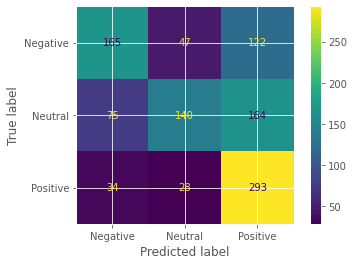

              precision    recall  f1-score   support

    negative       0.60      0.49      0.54       334
     neutral       0.65      0.37      0.47       379
    positive       0.51      0.83      0.63       355

    accuracy                           0.56      1068
   macro avg       0.59      0.56      0.55      1068
weighted avg       0.59      0.56      0.55      1068



<Figure size 432x288 with 0 Axes>

In [193]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
import matplotlib.pyplot as plt

cm = confusion_matrix(merged_df['annotator_combined'], merged_df['vader_sentiment'])

cmd = ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Neutral', 'Positive'])
cmd.plot()
plt.show()

plt.savefig('confusion_matrix_vader.png')
report = classification_report(merged_df['annotator_combined'], merged_df['vader_sentiment'], target_names=["negative", "neutral", "positive"])
print(report)

In [194]:
Negative = cm[0][0]/(cm[0][0]+cm[0][1]+cm[0][2])*100
print("Negative has a accuracy of {} %".format(Negative))

Neutral = cm[1][1]/(cm[1][1]+cm[1][0]+cm[1][2])*100
print("Neutral has a accuracy of {} %".format(Neutral))

Positive = cm[2][2]/(cm[2][2]+cm[2][0]+cm[2][1])*100
print("Positive has a accuracy of {} %".format(Positive))

Negative has a accuracy of 49.40119760479042 %
Neutral has a accuracy of 36.93931398416886 %
Positive has a accuracy of 82.53521126760563 %


In [195]:
accuracy = accuracy_score(merged_df['annotator_combined'], merged_df['textblob_sentiment'])
precision = precision_score(merged_df['annotator_combined'], merged_df['textblob_sentiment'], average='weighted')
recall = recall_score(merged_df['annotator_combined'], merged_df['textblob_sentiment'], average='weighted')
f1 = f1_score(merged_df['annotator_combined'], merged_df['textblob_sentiment'], average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.5093632958801498
Precision: 0.5356610130119512
Recall: 0.5093632958801498
F1 Score: 0.4911503482664172


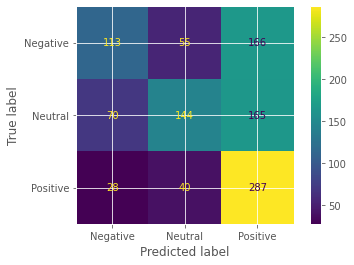

              precision    recall  f1-score   support

    negative       0.54      0.34      0.41       334
     neutral       0.60      0.38      0.47       379
    positive       0.46      0.81      0.59       355

    accuracy                           0.51      1068
   macro avg       0.53      0.51      0.49      1068
weighted avg       0.54      0.51      0.49      1068



<Figure size 432x288 with 0 Axes>

In [197]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(merged_df['annotator_combined'], merged_df['textblob_sentiment'])

cmd = ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Neutral', 'Positive'])
cmd.plot()
plt.show()
report = classification_report(merged_df['annotator_combined'], merged_df['textblob_sentiment'], target_names=["negative", "neutral", "positive"])
print(report)
plt.savefig('confusion_matrix_textblob.png')

In [174]:
Negative = cm[0][0]/(cm[0][0]+cm[0][1]+cm[0][2])*100
print("Negative has a accuracy of {} %".format(Negative))

Neutral = cm[1][1]/(cm[1][1]+cm[1][0]+cm[1][2])*100
print("Neutral has a accuracy of {} %".format(Neutral))

Positive = cm[2][2]/(cm[2][2]+cm[2][0]+cm[2][1])*100
print("Positive has a accuracy of {} %".format(Positive))

Negative has a accuracy of 33.83233532934132 %
Neutral has a accuracy of 37.994722955145114 %
Positive has a accuracy of 80.84507042253522 %


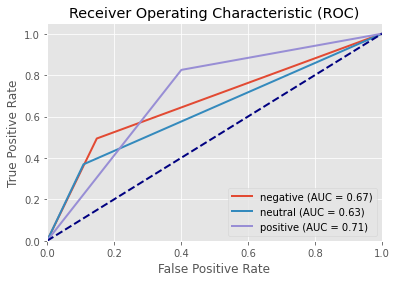

In [208]:

labels = merged_df['annotator_combined']
classes = ['negative', 'neutral', 'positive']
y_true = label_binarize(labels, classes=classes)

# Assuming 'positive' class is considered as the positive class
# Convert sentiment scores to binary predictions
predicted_scores = merged_df['vader_sentiment']
y_score = label_binarize(predicted_scores, classes=classes)
n_classes = len(classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for the positive class
# plt.figure()
# plt.plot(fpr[2], tpr[2], color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc[2])
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC)')
# plt.legend(loc="lower right")
# plt.show()

# plt.savefig('roc_vader.png')
plt.figure()
for i, class_name in enumerate(classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='%s (AUC = %0.2f)' % (class_name, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

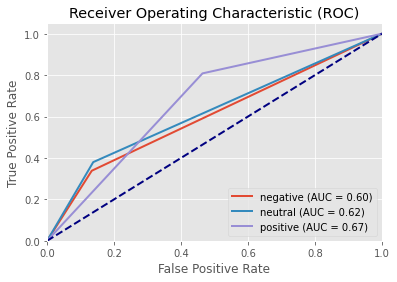

In [209]:
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

labels = merged_df['annotator_combined']
classes = ['negative', 'neutral', 'positive']
y_true = label_binarize(labels, classes=classes)

# Assuming 'positive' class is considered as the positive class
# Convert sentiment scores to binary predictions
predicted_scores = merged_df['textblob_sentiment']
y_score = label_binarize(predicted_scores, classes=classes)
n_classes = len(classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for the positive class
# plt.figure()
# plt.plot(fpr[2], tpr[2], color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc[2])
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC)')
# plt.legend(loc="lower right")
# plt.show()
# plt.savefig('roc_textblob.png')
plt.figure()
for i, class_name in enumerate(classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='%s (AUC = %0.2f)' % (class_name, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [204]:
sentiment_labels = ['positive', 'negative', 'neutral']

# Randomly assign sentiments to each text sample
random_sentiments = np.random.choice(sentiment_labels, size=len(merged_df))
merged_df['random_sentiment'] = random_sentiments
print(merged_df['annotator_combined'])
print(merged_df['random_sentiment'])

0        neutral
1       negative
2       positive
3       positive
4        neutral
          ...   
1191     neutral
1192    negative
1193     neutral
1194     neutral
1195    positive
Name: annotator_combined, Length: 1068, dtype: object
0       negative
1        neutral
2       positive
3       negative
4        neutral
          ...   
1191    positive
1192     neutral
1193    negative
1194     neutral
1195    positive
Name: random_sentiment, Length: 1068, dtype: object


In [211]:
n = len(vaders)
random_labels = np.random.choice(["negative", "neutral", "positive"], size=n)

predicted_labels = vaders['vader_sentiment']  

accuracy = accuracy_score(random_labels, predicted_labels)
print("Random Accuracy:", accuracy)

Random Accuracy: 0.3320706559170279


In [212]:
n = len(vaders)
random_labels = np.random.choice(["negative", "neutral", "positive"], size=n)

predicted_labels = vaders['textblob_sentiment']  

accuracy = accuracy_score(random_labels, predicted_labels)
print("Random Accuracy:", accuracy)

Random Accuracy: 0.3343191670380424
